# Solar ANN - Seasonal

### Load and preprocess data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('../../AutoCombine.csv')     # updated
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)

2025-02-04 12:41:35.130353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/lp/l5v0z5894r912dc6qp90m2j00000gn/T/ipykernel_12307/3186583987.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/dltc2020/Documents/Senior-project/Ml/getData/fuelWeatherCombined.csv')


In [4]:
# Find the latest date in the dataset
latest_date = data['BeginDate'].max()

# Get the month from the latest date
latest_month = latest_date.month

# Determine the season of the latest date
if latest_month in (12, 1, 2):
    season_months = [12, 1, 2]  # Winter
elif latest_month in (3, 4, 5):
    season_months = [3, 4, 5]  # Spring
elif latest_month in (6, 7, 8):
    season_months = [6, 7, 8]  # Summer
else:
    season_months = [9, 10, 11]  # Fall

# Filter the data to only include months from the same season as the latest date
data = data[data['BeginDate'].dt.month.isin(season_months)]

In [5]:
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)


In [10]:
# Calculate the average of 'Sum' for the latest month
# Filter the data to include only the rows from the latest month
latest_month_data = data[data['BeginDate'].dt.month == latest_month]

# Calculate the average of the 'Sum' column for the latest month
average_sum_latest_month = latest_month_data['Sum'].mean()
print(f"The average sum for the latest month ({latest_date.strftime('%Y-%m')}) is: {average_sum_latest_month}")

monthly_avg_sum = data.groupby(data['BeginDate'].dt.to_period("M"))['Sum'].mean()
# Display the average sum for each month
print(monthly_avg_sum)

latest_date = data['BeginDate'].max()
latest_month_period = latest_date.to_period("M")

# Get the average sum for the latest month
latest_month_avg_sum = monthly_avg_sum[latest_month_period]

# Calculate the scaling factor for each month
scaling_factors = latest_month_avg_sum / monthly_avg_sum

# Map the scaling factors back to the original dates in the dataframe
data['ScalingFactor'] = data['BeginDate'].dt.to_period("M").map(scaling_factors)

# Apply the scaling factors to each 'Sum' entry
data['AdjustedSum'] = data['Sum'] * data['ScalingFactor']
data['AdjustedSolar'] = data['Solar'] * data['ScalingFactor']

solar_data = data[['BeginDate', 'AdjustedSolar','Previous_Day','Previous_Year']].copy()

The average sum for the latest month (2024-12) is: 11110.603716400854
BeginDate
2021-12    10884.893254
2022-01    12109.617641
2022-02    11208.623425
2022-12    11345.796365
2023-01    11001.740688
2023-02    11156.062208
2023-12    11000.186551
2024-01    11952.686172
2024-02    10988.178832
2024-12    11431.265306
Freq: M, Name: Sum, dtype: float64


In [11]:
from bisect import bisect_left

def get_previous_day_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['AdjustedSolar'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [12]:
from bisect import bisect_left

def get_two_days_before_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['AdjustedSolar'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [13]:
from bisect import bisect_left

def get_previous_year_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['AdjustedSolar'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [14]:
# Large computation 
data['Previous_Year_Solar'] = data.apply(get_previous_year_Solar, axis=1, reference_df=solar_data)

In [15]:
cutoff_date = pd.to_datetime("2021-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Solar','Previous_Day','Previous_Year']].copy()

In [16]:


usable_data['Previous_Day_Solar'] = usable_data.apply(get_previous_day_Solar, axis=1, reference_df=solar_data)
usable_data['Previous_2Day_Solar'] = usable_data.apply(get_two_days_before_Solar, axis=1, reference_df=solar_data)


In [17]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Month'] = usable_data['BeginDate'].dt.month
usable_data['Year'] = usable_data['BeginDate'].dt.year
features = usable_data[['Month','Year','Previous_Year_Solar','Previous_2Day_Solar','AdjustedSum','temp', 'humidity', 'precip', 'uvindex', 'cloudcover', 'solarradiation','Previous_Day_Solar','solarenergy','Hour_of_Day','dew','dew','snow','snowdepth','windspeed','windgust']]

# Useless Features , 'winddir',,
target = usable_data['Solar']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (57312, 20)
Target shape:  (57312,)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [19]:
from tensorflow.keras import regularizers

from tensorflow.keras.layers import LeakyReLU
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, batch_size=128, callbacks=[early_stopping, lr_scheduler])

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


Epoch 1/500


/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 58.7694 - val_loss: 54.1848 - learning_rate: 0.0010
Epoch 2/500
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 49.7658 - val_loss: 44.2873 - learning_rate: 0.0010
Epoch 3/500
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.3106 - val_loss: 29.2978 - learning_rate: 0.0010
Epoch 4/500
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 29.3149 - val_loss: 22.0593 - learning_rate: 0.0010
Epoch 5/500
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.5767 - val_loss: 20.8047 - learning_rate: 0.0010
Epoch 6/500
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.8043 - val_loss: 18.3926 - learning_rate: 0.0010
Epoch 7/500
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.1375 - val_loss: 17.9924 - learning_rate: 0.0010
Epoch 8/500
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.3480 - val_loss: 16.7238 - learning_rate: 0.0010
Epoch 9/500
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.2760 - val_loss: 16.1355 - learning_rate: 0.

### Analysis

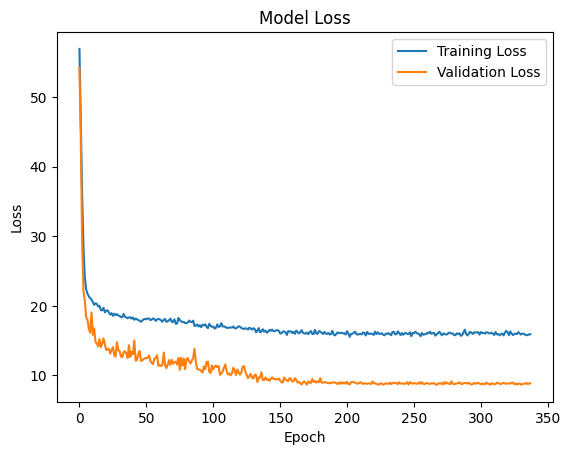

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [21]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
Predicted Solar Energy Ouput: [3.8727269172668457, 509.99395751953125, 2.047168731689453, 4.955155849456787, 0.7242593765258789, 1.3204565048217773, 198.98492431640625, 35.93510055541992, 15.786930084228516, 0.0, 1.7536331415176392, 120.72695922851562, 31.975669860839844, 4.231215000152588, 338.49359130859375, 22.975399017333984, 128.468505859375, 25.191295623779297, 277.7015686035156, 1.242236852645874]
Actual Solar Energy Output: [  2. 514.  10.   5.   0.   0. 208.  56.  10.   0.   0. 127.  23.   4.
 350.   5.  88.  30. 361.   1.]


In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 8.34362558987891
Mean Squared Error (MSE): 384.34769594339207
Root Mean Squared Error (RMSE): 19.604787577104528
Percent Error (PERR): 0.14335408755775345


### Save model

In [23]:
model.save('SolarModel.h5')